In [2]:
import numpy as np

in_data = np.load("/Users/ryan.gorzek/Downloads/retr02_002_001_stackred_seg_n3processed.npy", allow_pickle=True)
data = in_data.item()

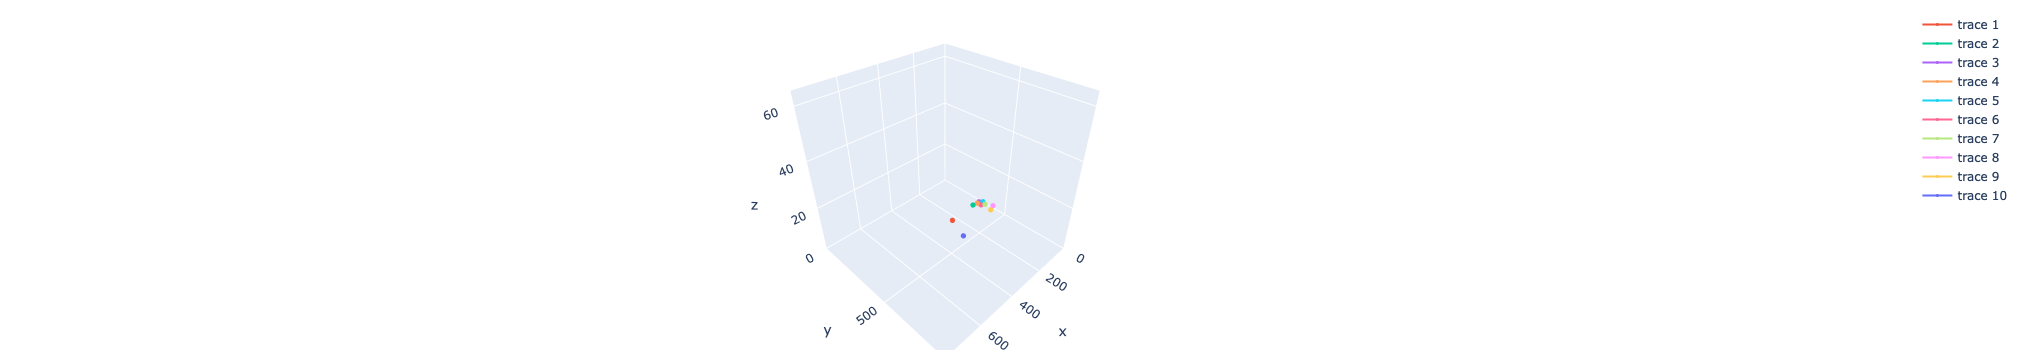

In [23]:
from skimage.measure import label, regionprops
import plotly.express as px

regions = regionprops(data["masks"])

fig = px.scatter_3d()
for region in regions[:10]:
    z, y, x = region.centroid
    fig.add_scatter3d(x=[x], y=[y], z=[z])
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[0, 795],),
        yaxis = dict(nticks=4, range=[0, 899],),
        zaxis = dict(nticks=4, range=[0, 65],),),
        width=700,
        margin=dict(r=20, l=10, b=10, t=10)
                )
fig.update_traces(marker_size = 3)
fig.show()